<a href="https://colab.research.google.com/github/moovingsloth/video-attention-classification/blob/main/DAiSEE_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B_%EB%B6%84%EC%84%9D_%EA%B8%B0%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install gcsfs tensorflow opencv-python tqdm --quiet

import gcsfs
from google.oauth2 import service_account
from google.colab import drive

drive.mount('/content/drive')

KEY_PATH = '/content/drive/MyDrive/keys/daisee-464310-abc81e54c985.json'
SCOPES = ['https://www.googleapis.com/auth/cloud-platform']

creds = service_account.Credentials.from_service_account_file(
    KEY_PATH,
    scopes=SCOPES
)
fs = gcsfs.GCSFileSystem(project='daisee-464310', token=creds)

GCS_DATASET_DIR = 'gs://colab-daisee-bucket/DAiSEE/DataSet/'
GCS_LABELS_DIR  = 'gs://colab-daisee-bucket/DAiSEE/Labels/'

print("GCSFS ready. KEY_PATH:", KEY_PATH)
print(fs.ls('colab-daisee-bucket/DAiSEE/DataSet/'))
print(fs.ls('colab-daisee-bucket/DAiSEE/Labels/'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GCSFS ready. KEY_PATH: /content/drive/MyDrive/keys/daisee-464310-abc81e54c985.json
['colab-daisee-bucket/DAiSEE/DataSet/', 'colab-daisee-bucket/DAiSEE/DataSet/Test', 'colab-daisee-bucket/DAiSEE/DataSet/Test.txt', 'colab-daisee-bucket/DAiSEE/DataSet/Train', 'colab-daisee-bucket/DAiSEE/DataSet/Train.txt', 'colab-daisee-bucket/DAiSEE/DataSet/Validation', 'colab-daisee-bucket/DAiSEE/DataSet/Validation.txt']
['colab-daisee-bucket/DAiSEE/Labels/AllLabels.csv', 'colab-daisee-bucket/DAiSEE/Labels/TestLabels.csv', 'colab-daisee-bucket/DAiSEE/Labels/TrainLabels.csv', 'colab-daisee-bucket/DAiSEE/Labels/ValidationLabels.csv']


In [24]:
import cv2
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
# Haar Cascade 알고리즘(사전 학습된(Pre-trained) 얼굴 검출 모델, xml 포맷)
HAAR_PATH = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
print("Using Haarcascade:", HAAR_PATH)

Using Haarcascade: /usr/local/lib/python3.11/dist-packages/cv2/data/haarcascade_frontalface_default.xml


In [28]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import cv2
from concurrent.futures import ThreadPoolExecutor, as_completed

# 목표: 손실, 누락된 비디오 파일을 사전에 제거
# 불완전한 프레임 건너뛰기 or 제거
# 프레임 길이가 너무 짧거나 비정상인 크기 필터링
# 타임윈도잉, 슬라이딩 윈도우 (LSTM, TCN 등에 넣을 고정된 시퀀스)
# 불필요한 노이즈 제거(얼굴 검출, ROI)
# 픽셀 레벨 정규화(normalization, equalizeHist())
# Data Augmentation: 좌우뒤집기, 랜덤 크롭, 회전, 색변환 / 시간축 뒤집기
# 클래스 불균형 처리: undersampling/oversampling / class_weight 조정
# one-hot encoding, label smoothing
# TFRecord/TF.Data 파이프라인 구성 - 캐싱, 셔플 등등

class DataPreprocessing:
    def __init__(self, fs, bucket: str, base_path: str = 'DAiSEE',
                 IMG_HEIGHT: int = 224, IMG_WIDTH: int = 224,
                 max_frames: int = 3, data_augmentation_flag: bool = False,
                 num_workers: int = 8):
        self.fs = fs
        self.bucket = bucket
        self.base_images = f'{bucket}/{base_path}/DataSet'
        self.base_labels = f'{bucket}/{base_path}/Labels'
        self.IMG_H, self.IMG_W = IMG_HEIGHT, IMG_WIDTH
        self.max_frames = max_frames
        self.data_augmentation_flag = data_augmentation_flag
        self.num_workers = num_workers
        # 얼굴 검출기 초기화
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        # 레이블 DataFrame 한 번만 로드
        self.label_dfs = {}
        for split in ('Train','Test','Validation'):
            path = f'{self.base_labels}/{split}Labels.csv'
            with self.fs.open(path,'rb') as f:
                self.label_dfs[split] = pd.read_csv(f)

    def get_video_paths(self, split: str) -> list:
        pattern = f'{self.base_images}/{split}/*/*/*'
        vids = [p for p in self.fs.glob(pattern) if p.lower().endswith(('.avi','.mp4'))]
        print(f"{split}: found {len(vids)} videos")
        return vids

    def extract_frames(self, video_path: str) -> list:
        # 임시 로컬 파일로 프레임 추출 (Thread-safe 작업)
        tmp = '/tmp/tmp_video.avi'
        with self.fs.open(video_path,'rb') as src, open(tmp,'wb') as dst:
            dst.write(src.read())
        cap = cv2.VideoCapture(tmp)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, total-1, self.max_frames, dtype=int)
        frames = []
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
            ret, frame = cap.read()
            if not ret: break
            # BGR -> RGB 변환
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        cap.release()
        return frames

    def face_cropping(self, image: np.ndarray) -> np.ndarray:
        # 얼굴 검출 및 크롭, 리사이즈
        faces = self.face_cascade.detectMultiScale(image,1.3,5)
        if len(faces)>0:
            x,y,w,h = faces[0]
            image = image[y:y+h, x:x+w]
        return cv2.resize(image,(self.IMG_W,self.IMG_H), interpolation=cv2.INTER_AREA)

    def augment_image(self, image: np.ndarray) -> list:
        # 간단 증강 연산 정의
        ops = [
            lambda x: tf.image.flip_left_right(x).numpy(),
            lambda x: tf.image.random_brightness(x,0.2).numpy(),
            lambda x: tf.image.random_contrast(x,0.8,1.2).numpy()
        ]
        variants = []
        for op in ops:
            aug = op(image)
            variants.append(cv2.resize(aug,(self.IMG_W,self.IMG_H)))
        return variants

    def _bytes_feature(self, value: bytes) -> tf.train.Feature:
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def label_onehot(self, video_path: str, split: str) -> bytes:
        # ClipID 기준 레이블 조회 및 one-hot 변환
        vid = os.path.basename(video_path).rsplit('.',1)[0] + '.avi'
        df = self.label_dfs[split]
        row = df[df['ClipID']==vid]
        if row.empty: return None
        arr = row[['Boredom','Engagement','Confusion','Frustration ']].values[0]

        # Correctly create a one-hot encoded label
        # Find the index of the maximum value
        max_index = np.argmax(arr)
        # Create a one-hot array
        one_hot_label = np.zeros(4, dtype=np.uint8)
        one_hot_label[max_index] = 1

        return one_hot_label.tobytes()


    def _process_video(self, video_path: str, split: str) -> list:
        # 비디오 단위 TFRecord Example 생성
        lab = self.label_onehot(video_path, split)
        if lab is None: return []
        examples = []
        frames = self.extract_frames(video_path)
        for frame in frames:
            img = self.face_cropping(frame)
            variants = self.augment_image(img) if self.data_augmentation_flag else [img]
            for v in variants:
                jpeg = tf.io.encode_jpeg(v).numpy()
                feat = {
                    'image': self._bytes_feature(jpeg),
                    'label': self._bytes_feature(lab)
                }
                examples.append(tf.train.Example(features=tf.train.Features(feature=feat)))
        return examples

    def writeTfRecord(self, output_dir: str = 'tfrecords'):
        # Train/Test/Validation 동시 처리, 스레딩 적용
        os.makedirs(output_dir,exist_ok=True)
        for split in ('Train','Test','Validation'):
            paths = self.get_video_paths(split)
            writer = tf.io.TFRecordWriter(f'{output_dir}/{split.lower()}.tfrecords')
            with ThreadPoolExecutor(max_workers=self.num_workers) as exe:
                futures = {exe.submit(self._process_video, vp, split): vp for vp in paths}
                for future in tqdm(as_completed(futures), total=len(paths), desc=split):
                    for ex in future.result():
                        writer.write(ex.SerializeToString())
            writer.close()

    def decode(self, example):
        # TFRecord 파싱 및 디코딩
        features = {
            'image': tf.io.FixedLenFeature([],tf.string),
            'label': tf.io.FixedLenFeature([],tf.string)
        }
        ex = tf.io.parse_single_example(example, features)
        img = tf.image.decode_jpeg(ex['image'],channels=3)
        lab = tf.io.decode_raw(ex['label'],tf.uint8)
        return img, tf.cast(lab,tf.float32)

In [31]:
# 1) TensorFlow 불러오기
import tensorflow as tf

# 2) 배치 크기 설정
batch_size = 32

# 3) DataPreprocessing 인스턴스 생성
dp = DataPreprocessing(
    fs=fs,
    bucket='colab-daisee-bucket',
    max_frames=3,
    data_augmentation_flag=False,  # 이 플래그로 증강 on/off 제어
    num_workers=8
)

# 4) TFRecord 파일 생성
dp.writeTfRecord('tfrecords')  # writeTfRecord(output_dir)만 받습니다

# 5) TFRecordDataset + dp.decode + batch
ds = tf.data.TFRecordDataset('tfrecords/train.tfrecords')
ds = ds.map(dp.decode, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(batch_size)

# 6) 첫 배치 확인
for imgs, labs in ds.take(1):
    print('batch images:', imgs.shape, 'labels:', labs.shape)

Train: found 5482 videos


Train: 100%|██████████| 5482/5482 [21:23<00:00,  4.27it/s] 


Test: found 1866 videos


Test: 100%|██████████| 1866/1866 [05:29<00:00,  5.67it/s]


Validation: found 1720 videos


Validation: 100%|██████████| 1720/1720 [04:18<00:00,  6.65it/s] 

batch images: (32, 224, 224, 3) labels: (32, 4)


In [21]:
# dp = DataPreprocessing(fs=fs, bucket='colab-daisee-bucket', max_frames=3, data_augmentation_flag=True)
# dp.writeTfRecord('tfrecords', data_augmentation=True)

# ds = tf.data.TFRecordDataset('tfrecords/train.tfrecords')
# ds = ds.map(dp.decode).batch(batch_size)
# for imgs, labs in ds.take(1):
#     print('batch images:', imgs.shape, 'labels:', labs.shape)

Train 분할 레이블 분포: [2570 9694  135   87]
Validation 분할 레이블 분포: [1347 2123   31   35]
Test 분할 레이블 분포: [ 784 3289   46   44]


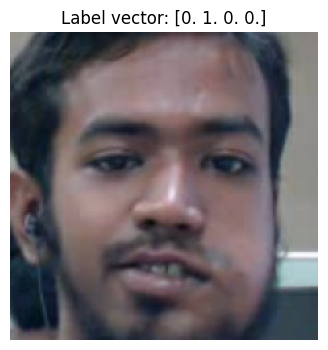

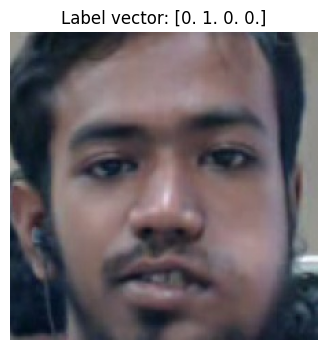

In [32]:
'''
시각화 및 레이블 분포(불균형 확인)

메모리 캐시로 디스크 I/O 디코빙 비용 절감?
'''
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# 1) TFRecord 파일 경로 설정
train_tfrecord = 'tfrecords/train.tfrecords'
val_tfrecord   = 'tfrecords/validation.tfrecords'
test_tfrecord  = 'tfrecords/test.tfrecords'

# 2) 레이블 디코딩 함수 (DataPreprocessing.decode와 동일)
def decode(example_proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    ex = tf.io.parse_single_example(example_proto, features)
    img = tf.image.decode_jpeg(ex['image'], channels=3)
    lab = tf.io.decode_raw(ex['label'], tf.uint8)
    return img, tf.cast(lab, tf.float32)

# 3) 데이터셋 읽어오기
def make_dataset(tfrecord_path, batch_size=32):
    ds = tf.data.TFRecordDataset(tfrecord_path)
    ds = ds.map(decode, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_tfrecord, batch_size=32)
val_ds   = make_dataset(val_tfrecord,   batch_size=32)
test_ds  = make_dataset(test_tfrecord,  batch_size=32)

# ——————————————————————————————
# A) 샘플 시각화
# ——————————————————————————————
for imgs, labs in train_ds.take(1):
    # 두 장만 꺼내서
    for i in [0, 1]:
        plt.figure(figsize=(4,4))
        plt.imshow(imgs[i].numpy().astype(np.uint8))
        plt.title(f"Label vector: {labs[i].numpy()}")
        plt.axis('off')
    break

# ——————————————————————————————
# B) 레이블 분포 확인
# ——————————————————————————————
def label_distribution(ds, name):
    counts = np.zeros(4, dtype=int)
    for _, labs in ds:
        # labs: (batch, 4) one-hot 혹은 float 레이블
        idx = np.argmax(labs.numpy(), axis=1)
        binc = np.bincount(idx, minlength=4)
        counts += binc
    print(f"{name} 분할 레이블 분포:", counts)

label_distribution(train_ds, "Train")
label_distribution(val_ds,   "Validation")
label_distribution(test_ds,  "Test")

In [30]:
import pandas as pd
import numpy as np
import gcsfs
from google.oauth2 import service_account
from google.colab import drive

# Assuming drive is already mounted and creds/fs are initialized from the previous cells
# drive.mount('/content/drive')
# KEY_PATH = '/content/drive/MyDrive/keys/daisee-464310-abc81e54c985.json'
# SCOPES = ['https://www.googleapis.com/auth/cloud-platform']
# creds = service_account.Credentials.from_service_account_file(
#     KEY_PATH,
#     scopes=SCOPES
# )
# fs = gcsfs.GCSFileSystem(project='daisee-464310', token=creds)


GCS_LABELS_DIR  = 'gs://colab-daisee-bucket/DAiSEE/Labels/'
# Correcting the path to avoid double slashes
test_labels_path = f'{GCS_LABELS_DIR}TestLabels.csv'

with fs.open(test_labels_path, 'rb') as f:
    test_df = pd.read_csv(f)

# Calculate label distribution
# Assuming the label columns are 'Boredom', 'Engagement', 'Confusion', 'Frustration '
label_columns = ['Boredom', 'Engagement', 'Confusion', 'Frustration ']
label_counts = test_df[label_columns].apply(lambda x: np.argmax(x.values), axis=1).value_counts().sort_index()

# The indices of label_counts correspond to the index of the dominant label in the label_columns list
# We need to map these indices back to the label names for clarity
label_names = ['Boredom', 'Engagement', 'Confusion', 'Frustration'] # Correcting 'Frustration '

# Create a dictionary for mapping index to label name
index_to_label = {i: label_names[i] for i in range(len(label_names))}

# Map the index in label_counts to the actual label names
labeled_distribution = label_counts.rename(index_to_label)

print("Label distribution for TestLabels.csv:")
display(labeled_distribution)

Label distribution for TestLabels.csv:


,count
Boredom,317
Engagement,1432
Confusion,18
Frustration,17
